In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
import astropy.coordinates as coord
import astropy.units as u
from itertools import permutations, product
from astropy.io import ascii

In [2]:
# select most recent training data
train_file = 'training_data_0802.pk' # training data with 3 classes
train_file = 'training_data_1702.pk' # training data with only gcs and galaxies
#train_file = 'training_data_1902_with_stars.pk' # training data with gcs galaxies and stars, classed as 'gc' and 'non-gc'
#train_file = 'training_data_2702_j.pk'

# load training data and filter out stars
with open(f'./pickle/training_data/{train_file}','rb') as f:
    training_data = pickle.load(f)

In [3]:
bounds = pickle.load(open('./pickle/bounds.pk','rb'))
master_cat = pd.read_csv('./catdata/master_catalog_jan_2023.csv') #2184 objects long
cat_files = ['cat1_50.pk','cat51_100.pk','cat101_150.pk','cat151_200.pk','cat201_235.pk',
             'cat236_257.pk','cat258_279.pk','cat280_320.pk','cat321_360.pk','cat361_406.pk']

#cat files but filtered down to only 2MASS matches
cat_files_filtered = ['cat1_50_filtered.pk','cat51_100_filtered.pk','cat101_150_filtered.pk','cat151_200_filtered.pk','cat201_235_filtered.pk',
             'cat236_257_filtered.pk','cat258_279_filtered.pk','cat280_320_filtered.pk','cat321_360_filtered.pk','cat361_406_filtered.pk']
def load_cat(field, filtered=False): # change to match-case
    bounds = [50,100,150,200,235,257,279,320,360,406]
    for b in range(len(bounds)):
        if field <= bounds[b]:
            if filtered: to_load = cat_files_filtered[b]
            else: to_load = cat_files[b]
            break
    with open(f'./pickle/{to_load}','rb') as f:
        catalogue = pickle.load(f)
    return catalogue[field] # 26/02 changed to return only the selected field

## 26/02/23 Defining useful functions
Functions for finding mid points of fields etc. to help with catalog matching

In [4]:
# find the mid point of a given field (returns a 2-tuple of coordinates)
# note: bounds file has already taken into account the 0 RA issue and holds negative values, rather than e.g. RA=358
def find_middle(field: int) -> tuple:
    field_bounds = bounds[field]
    ra_width = abs( field_bounds[0]-field_bounds[1] )/2
    dec_width = abs( field_bounds[2]-field_bounds[3] )/2
    ra_mid = field_bounds[1]+ra_width
    dec_mid = field_bounds[2]+dec_width
    return (ra_mid,dec_mid)

In [5]:
# returns true if a given point is found to be within a specified field
# takes a 2-tuple: (ra,dec) in degrees
def is_in_field(field: int, point: tuple) -> bool:
    ra1,ra2,dec1,dec2 = bounds[field]
    ra,dec=point
    return ra2<ra<ra1 and dec1<dec<dec2

### Get list of required fields to get 2MASS data in

In [6]:
req_fields = list(set(training_data['field']))

In [7]:
middles=[]
for f in req_fields:
    middles.append((f,find_middle(f)))

In [121]:
with open('./pickle/middles.txt','w') as f:
    for i in middles:
        f.writelines(str(i)+'\n')

## #####

In [8]:
field=5
train_obj = training_data[training_data['field']==field]

_2MASS_table = ascii.read(f'./catdata/2mass/{field}.tbl', format='ipac').to_pandas()
_2MASS_table = _2MASS_table[_2MASS_table['ph_qual'].isin(ABC)].reset_index()
#_2MASS_table = _2MASS_table[(_2MASS_table['ra']<8.35) & (_2MASS_table['ra']>8.05) & (_2MASS_table['dec']<48.6) & (_2MASS_table['dec']>48.3)]

cat = load_cat(field)
#cat = cat[(cat['RA']<8.35) & (cat['RA']>8.05) & (cat['Dec']<48.6) & (cat['Dec']>48.3)]

NameError: name 'ABC' is not defined

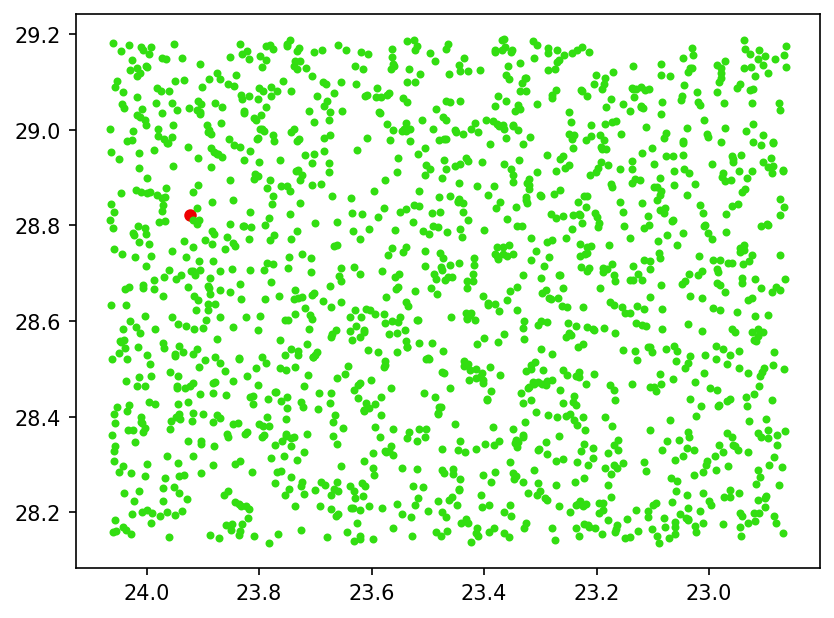

In [15]:
#plt.scatter(cat['RA'],cat['Dec'],c='#2211ee',s=4)
plt.figure(dpi=150)
plt.scatter(training_data[training_data['field']==field]['ra'],training_data[training_data['field']==field]['dec'],c='#ee0000',s=25)
plt.scatter(_2MASS_table['ra'],_2MASS_table['dec'],c='#32de11',s=8)
plt.gca().invert_xaxis()

In [194]:
training_data[training_data['obj_id']=='SD-GC7']

,obj_id,class,i,g,di,dg,ra,dec,field,pdidx,rbcidx,nearby,i-g,j
1317,SD-GC7,gc,17.462,18.429001,0.001,0.001,8.0925,48.524174,395,112894,64,85,-0.967001,15.667


In [214]:
c1 = coord.SkyCoord(8.0925, 48.524174, unit=(u.degree, u.degree))

In [217]:
d2 = _2MASS_table[(_2MASS_table['ra']<8.1) & (_2MASS_table['ra']>8.0) & (_2MASS_table['dec']<48.53) & (_2MASS_table['dec']>48.52)]

In [218]:
ra_qry, dec_qry = d2['ra'], d2['dec']

In [219]:
c2 = coord.SkyCoord(ra_qry, dec_qry, unit=(u.degree, u.degree))

In [220]:
c2

<SkyCoord (ICRS): (ra, dec) in deg
    [(8.060301, 48.523003), (8.007499, 48.527969), (8.092494, 48.524208)]>

In [221]:
idx, d2d, _ = c1.match_to_catalog_sky(c2)

In [228]:
d1 = _2MASS_table
ra_obs, dec_obs = d1['ra'], d1['dec']
d2 = training_data[training_data['field']==395]
ra_qry, dec_qry = d2['ra'], d2['dec']

c1 = coord.SkyCoord(ra_obs, dec_obs, unit=(u.degree, u.degree))
c2 = coord.SkyCoord(ra_qry, dec_qry, unit=(u.degree, u.degree))
idx, d2d, _ = c2.match_to_catalog_sky(c1)

In [230]:
d2

,obj_id,class,i,g,di,dg,ra,dec,field,pdidx,rbcidx,nearby,i-g,j
1317,SD-GC7,gc,17.462000,18.429001,0.001,0.001,8.092500,48.524174,395,112894,64,85,-0.967001,15.667
1318,SD-GC5,gc,19.569000,20.409000,0.003,0.003,8.095484,48.430168,395,113063,65,98,-0.840000,14.602
1319,PA-N147-1,gc,17.424000,18.291000,0.001,0.001,8.147034,48.329792,395,218780,66,120,-0.867001,15.735
1320,SD-GC10,gc,21.725000,22.632000,0.018,0.013,8.196683,48.536232,395,113447,69,157,-0.907000,16.233
1321,Hodge-I,gc,18.325001,19.246000,0.002,0.002,8.300700,48.508938,395,60703,70,262,-0.921000,14.531
1322,Hodge-II,gc,19.056999,20.073999,0.003,0.003,8.306500,48.480087,395,60778,72,230,-1.017000,15.707
1323,Hodge-IV,gc,20.549000,21.561001,0.009,0.008,8.312658,48.535927,395,60949,74,267,-1.012001,15.742
1324,Hodge-III,gc,17.572001,18.465000,0.001,0.001,8.313167,48.456367,395,60636,75,192,-0.893000,15.574


In [229]:
idx, d2d

array([1784, 4669, 4693,  185,  302,  213,  285,  227], dtype=int64)

# 2MASS Catalogue matching

In [40]:
# match objects from 2MASS to pandas
# take ra dec from 2mass and match to ra dec in pandas
# find all close matches (<0.001deg??)
# add chosen filter to data
def match_2mass_pandas(field, tbl_2mass=None):
    cat = load_cat(field, filtered=False)
    if tbl_2mass is None:
        tbl_2mass = get_filtered_2mass(field)
    d1 = tbl_2mass
    ra_obs, dec_obs = d1['ra'], d1['dec']
    d2 = cat
    ra_qry, dec_qry = d2['RA'], d2['Dec']

    c1 = coord.SkyCoord(ra_obs, dec_obs, unit=(u.degree, u.degree))
    c2 = coord.SkyCoord(ra_qry, dec_qry, unit=(u.degree, u.degree))
    idx, d2d, _ = c1.match_to_catalog_sky(c2)
    d2d = d2d.degree
    
    in_range = [d2d[i]<=0.001 for i in range(len(idx))]
    return idx, in_range #idx: the index of the object in 2MASS, d2d: distance to that object

In [16]:
# match 2mass to objects in training_data
# returns a list of indexes in 2MASS which correspond to each item in the training_data
def match_2mass_train(field, tbl_2mass):
    d1 = tbl_2mass
    ra_obs, dec_obs = d1['ra'], d1['dec']
    d2 = training_data[training_data['field']==field]
    ra_qry, dec_qry = d2['ra'], d2['dec']

    c1 = coord.SkyCoord(ra_obs, dec_obs, unit=(u.degree, u.degree))
    c2 = coord.SkyCoord(ra_qry, dec_qry, unit=(u.degree, u.degree))
    idx, d2d, _ = c2.match_to_catalog_sky(c1)
    d2d = d2d.degree
    in_range = [d2d[i]<=0.001 for i in range(len(idx))]
    return idx, in_range #idx: the index of the object in 2MASS, d2d: distance to that object

In [11]:
def get_filtered_2mass(field:int):
    ABC = [''.join(p) for p in product('ABC','ABC','ABC')] # all permutations of A,B,C quality results
    filtered_table = ascii.read(f'./catdata/2mass/{field}.tbl', format='ipac').to_pandas()
    filtered_table = filtered_table[filtered_table['ph_qual'].isin(ABC)].reset_index()
    return filtered_table

## Matching 2MASS to PAndAS Testing

In [68]:
cat = load_cat(35)

In [69]:
matched35 = match_2mass_pandas(35)

In [70]:
field35_2mass = get_filtered_2mass(35)

In [71]:
matched35[0]

array([182060, 181994, 181955, ..., 145792, 145776, 145507], dtype=int64)

In [72]:
cat_filtered = cat[matched35[0]]

In [74]:

cat_filtered['j'] = field35_2mass['j_m']
cat_filtered['h'] = field35_2mass['h_m']
cat_filtered['k'] = field35_2mass['k_m']

In [75]:
cat_filtered

RA,Dec,iccd,xg,yg,g,dg,ig,xi,yi,i,di,ii,ia,field,j,h,k
float32,float32,uint8,float32,float32,float32,float32,int8,float32,float32,float32,float32,int8,int8,uint16,float64,float64,float64
14.318621,30.95488,34,863.83,3216.62,20.787,0.004,-1,870.42,3213.91,18.466,0.002,-1,0,35,16.774,15.566,15.449
14.280267,30.90918,34,1507.79,2327.41,17.561,0.001,-9,1513.89,2324.46,16.372,0.001,-9,0,35,15.091,14.391,14.386
14.309691,30.91289,34,1017.9,2399.99,13.117,0.001,-9,1024.09,2397.21,13.184,0.001,-9,0,35,7.714,7.233,7.052
14.352217,30.911316,34,311.58,2369.89,20.269,0.003,1,317.83,2367.34,18.689,0.002,1,0,35,16.315,15.58,15.14
14.323559,30.937962,34,784.05,2887.82,15.855,0.001,-9,790.49,2885.12,15.465,0.001,-9,0,35,14.696,14.342,14.161
14.327455,30.940033,34,719.1,2928.13,15.728,0.001,-9,725.58,2925.46,15.245,0.001,-9,0,35,14.37,14.025,13.872
14.339288,30.925722,34,524.49,2650.0,16.625,0.001,-9,530.85,2647.39,15.692,0.001,-9,0,35,14.489,13.942,13.898
14.30655,30.944477,34,1065.67,3014.41,20.3,0.003,-1,1072.15,3011.63,17.813,0.001,-1,0,35,15.747,15.096,14.794
14.288896,30.824612,34,1377.89,676.76,17.252,0.001,-9,1383.22,673.79,16.398,0.001,-9,0,35,15.241,14.697,14.591


In [66]:
cat[matched35[0]]['j'] = field35_2mass['j_m']

In [45]:
field35_2mass

,index,ra,dec,err_maj,err_min,err_ang,designation,j_m,j_cmsig,j_msigcom,...,ph_qual,rd_flg,bl_flg,cc_flg,ndet,gal_contam,mp_flg,j_h,h_k,j_k
0,1,14.318652,30.954897,0.21,0.20,99,00571647+3057176,16.774,0.164,0.164,...,CBC,222,111,000,060615,0,0,1.208,0.117,1.325
1,3,14.280216,30.909168,0.07,0.06,173,00570725+3054330,15.091,0.041,0.043,...,AAA,222,111,000,663636,0,0,0.700,0.005,0.705
2,4,14.309876,30.912947,0.07,0.06,0,00571437+3054466,7.714,0.017,0.024,...,AAA,111,111,000,666666,0,0,0.481,0.181,0.662
3,6,14.352153,30.911264,0.18,0.17,82,00572451+3054405,16.315,0.118,0.119,...,BCB,222,111,000,060516,0,0,0.735,0.440,1.175
4,7,14.323594,30.937975,0.07,0.06,176,00571766+3056167,14.696,0.031,0.033,...,AAA,222,111,000,666634,0,0,0.354,0.181,0.535
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2466,3118,14.011533,31.084261,0.28,0.27,104,00560276+3105033,16.754,0.180,0.181,...,CCC,222,111,000,060606,0,0,0.763,0.593,1.356
2467,3119,13.957618,31.071966,0.07,0.06,90,00554982+3104190,13.389,0.020,0.024,...,AAA,222,111,000,666666,0,0,0.412,0.122,0.534
2468,3121,13.987149,31.071211,0.08,0.07,83,00555691+3104163,15.353,0.056,0.058,...,AAB,222,111,000,662605,0,0,0.488,-0.145,0.343
2469,3122,13.958564,31.093937,0.07,0.06,90,00555005+3105381,15.169,0.045,0.047,...,AAA,222,111,000,555516,0,0,0.856,-0.079,0.777


In [33]:
matched35

(array([ 975,  966,  939, ..., 1730, 1786, 1786], dtype=int64),
 [True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  True,
  False,
  True,
  True,
  True,
  True,
  True,
  True,
  False,
  False,
  True,
  False,
  True,
  True,
  True,
  True,
  True,
  True,
  False,
  False,
  True,
  False,
  True,
  False,
  True,
  False,
  False,
  True,
  True,
  True,
  False,
  False,
  True,
  False,
  False,
  False,
  True,
  True,
  False,
  True,
  False,
  True,
  False,
  False,
  True,
  True,
  True,
  True,
  False,
  False,
  False,
  False,
  True,
  True,
  False,
  False,
  False,
  True,
  False,
  False,
  False,
  True,
  False,
  True,
  False,
  False,
  True,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  True,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  False,
  True,
  Tr

In [18]:
cat = load_cat(35)

In [19]:
# drop rows with high delta g/i values
cat_d = cat[cat['dg']+cat['di'] < 0.05]
# drop stars & saturated points
cat_candidate = cat_d[(cat_d['ig'] == 1) & (cat_d['ii'] == 1)]
# add in i-g feature
cat_candidate['i-g'] = cat_candidate['i']-cat_candidate['g']
# add in j feature

In [20]:
get_filtered_2mass(35)

,index,ra,dec,err_maj,err_min,err_ang,designation,j_m,j_cmsig,j_msigcom,...,ph_qual,rd_flg,bl_flg,cc_flg,ndet,gal_contam,mp_flg,j_h,h_k,j_k
0,1,14.318652,30.954897,0.21,0.20,99,00571647+3057176,16.774,0.164,0.164,...,CBC,222,111,000,060615,0,0,1.208,0.117,1.325
1,3,14.280216,30.909168,0.07,0.06,173,00570725+3054330,15.091,0.041,0.043,...,AAA,222,111,000,663636,0,0,0.700,0.005,0.705
2,4,14.309876,30.912947,0.07,0.06,0,00571437+3054466,7.714,0.017,0.024,...,AAA,111,111,000,666666,0,0,0.481,0.181,0.662
3,6,14.352153,30.911264,0.18,0.17,82,00572451+3054405,16.315,0.118,0.119,...,BCB,222,111,000,060516,0,0,0.735,0.440,1.175
4,7,14.323594,30.937975,0.07,0.06,176,00571766+3056167,14.696,0.031,0.033,...,AAA,222,111,000,666634,0,0,0.354,0.181,0.535
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2466,3118,14.011533,31.084261,0.28,0.27,104,00560276+3105033,16.754,0.180,0.181,...,CCC,222,111,000,060606,0,0,0.763,0.593,1.356
2467,3119,13.957618,31.071966,0.07,0.06,90,00554982+3104190,13.389,0.020,0.024,...,AAA,222,111,000,666666,0,0,0.412,0.122,0.534
2468,3121,13.987149,31.071211,0.08,0.07,83,00555691+3104163,15.353,0.056,0.058,...,AAB,222,111,000,662605,0,0,0.488,-0.145,0.343
2469,3122,13.958564,31.093937,0.07,0.06,90,00555005+3105381,15.169,0.045,0.047,...,AAA,222,111,000,555516,0,0,0.856,-0.079,0.777


In [21]:
cat

RA,Dec,iccd,xg,yg,g,dg,ig,xi,yi,i,di,ii,ia,field
float32,float32,uint8,float32,float32,float32,float32,int8,float32,float32,float32,float32,int8,int8,uint16
15.117217,31.68157,1,1780.06,2125.69,13.363,0.001,-9,1765.6,2120.99,13.293,0.001,-9,0,35
15.073417,31.626534,1,1045.97,3208.58,13.392,0.001,-9,1032.06,3203.84,13.312,0.001,-9,0,35
15.026433,31.693539,1,269.19,1910.09,13.491,0.001,-9,254.58,1905.83,13.255,0.001,-9,0,35
15.090321,31.721361,1,1334.98,1353.0,13.523,0.001,-9,1320.09,1348.51,13.415,0.001,-9,0,35
15.075942,31.765406,1,1099.87,492.69,13.542,0.001,-9,1084.52,488.35,13.369,0.001,-9,0,35
15.112083,31.614477,1,1689.69,3436.29,13.562,0.001,-9,1675.92,3431.31,13.4,0.001,-9,0,35
15.055783,31.585936,1,750.46,4001.77,13.582,0.001,-9,736.96,3997.05,13.459,0.001,-9,0,35
15.0532875,31.656134,1,712.85,2635.24,13.802,0.001,-9,698.64,2630.74,13.622,0.001,-9,0,35
15.1059,31.658348,1,1589.38,2581.74,13.92,0.001,-9,1575.15,2576.98,13.771,0.001,-9,0,35


## Add J,H,K columns to training data

In [23]:
# select most recent training data
train_file = 'training_data_0802.pk' # training data with 3 classes
train_file = 'training_data_1702.pk' # training data with only gcs and galaxies
#train_file = 'training_data_1902_with_stars.pk' # training data with gcs galaxies and stars, classed as 'gc' and 'non-gc'
train_file = 'training_data_2702_j.pk'
train_file = 'training_data_0203_jhk.pk'

with open(f'./pickle/training_data/{train_file}','rb') as f:
    training_data = pickle.load(f)

In [24]:
training_data

,obj_id,class,i,g,di,dg,ra,dec,field,pdidx,rbcidx,nearby,i-g,j,h,k,ph_qual,2mass_acc
0,HM33-A,gc,22.424000,22.940001,0.026,0.017,23.923733,28.821186,5,39800,2647,49,-0.516001,13.028,12.881,12.805,AAA,False
1,C30,galaxy,18.049000,19.500999,0.001,0.002,12.105896,29.267633,11,118854,2431,24,-1.452000,15.869,15.216,14.756,AAB,True
2,LAMOST-C22,galaxy,17.628000,19.153000,0.001,0.001,11.738621,29.693506,11,24692,2319,17,-1.525000,15.251,14.503,13.918,AAA,True
3,HM33-B,gc,19.538000,20.386000,0.003,0.003,24.008787,29.963625,13,43246,2648,45,-0.848000,16.429,15.589,15.154,BBC,False
4,LAMOST-C18,galaxy,17.177999,18.388000,0.001,0.001,23.842129,29.552473,14,122860,2644,12,-1.210001,14.838,14.277,13.847,AAA,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1329,PA-N185,gc,20.188000,21.688999,0.005,0.007,9.578100,48.367985,398,256376,306,106,-1.500999,11.881,11.436,11.314,AAA,False
1330,FJJ-V,gc,17.434999,18.451000,0.001,0.001,9.806167,48.384743,398,168423,372,156,-1.016001,13.321,12.966,12.889,AAA,False
1331,FJJ-VII,gc,19.523001,20.520000,0.003,0.004,9.826713,48.384266,398,168594,377,163,-0.997000,14.687,14.317,14.254,AAA,False
1332,PA-N147-3,gc,19.910000,20.820999,0.004,0.004,8.542029,49.044243,402,101369,91,36,-0.910999,14.378,13.857,13.694,AAA,False


In [60]:
for f in req_fields:
    print(f'Field: {f}')
    _2MASS_table = get_filtered_2mass(f)
    idx,in_range = match_2mass_train(f,_2MASS_table)
    training_data_indexes = training_data[training_data['field']==f].index
    for i in range(len(idx)):
        training_data.loc[training_data_indexes[i],'j'] = _2MASS_table.loc[idx[i],'j_m']
        training_data.loc[training_data_indexes[i],'h'] = _2MASS_table.loc[idx[i],'h_m']
        training_data.loc[training_data_indexes[i],'k'] = _2MASS_table.loc[idx[i],'k_m']
        training_data.loc[training_data_indexes[i],'ph_qual'] = _2MASS_table.loc[idx[i],'ph_qual']
        training_data.loc[training_data_indexes[i],'2mass_acc'] = in_range[i]

Field: 5
Object 0 with 2MASS index 1075 is far (0.0114 deg) from true position
Field: 11
Field: 13
Object 0 with 2MASS index 124 is far (0.0209 deg) from true position
Field: 14
Field: 20
Object 0 with 2MASS index 1881 is far (0.0092 deg) from true position
Field: 22
Object 0 with 2MASS index 1277 is far (0.0129 deg) from true position
Field: 24
Object 1 with 2MASS index 2505 is far (0.0153 deg) from true position
Field: 25
Field: 33
Field: 35
Object 0 with 2MASS index 1213 is far (0.0061 deg) from true position
Field: 37
Object 0 with 2MASS index 429 is far (0.0089 deg) from true position
Field: 43
Object 0 with 2MASS index 941 is far (0.0264 deg) from true position
Field: 52
Object 0 with 2MASS index 657 is far (0.0035 deg) from true position
Field: 58
Object 1 with 2MASS index 1159 is far (0.0091 deg) from true position
Field: 62
Object 0 with 2MASS index 2373 is far (0.0080 deg) from true position
Field: 70
Object 0 with 2MASS index 2256 is far (0.0207 deg) from true position
Field

Object 8 with 2MASS index 2038 is far (0.0054 deg) from true position
Object 16 with 2MASS index 2132 is far (0.0071 deg) from true position
Field: 238
Object 0 with 2MASS index 1786 is far (0.0045 deg) from true position
Field: 240
Object 0 with 2MASS index 2965 is far (0.0050 deg) from true position
Object 1 with 2MASS index 2855 is far (0.0055 deg) from true position
Object 2 with 2MASS index 2965 is far (0.0056 deg) from true position
Field: 243
Object 0 with 2MASS index 3230 is far (0.0076 deg) from true position
Field: 248
Object 1 with 2MASS index 4311 is far (0.0059 deg) from true position
Object 5 with 2MASS index 211 is far (0.0015 deg) from true position
Object 7 with 2MASS index 4583 is far (0.0039 deg) from true position
Object 10 with 2MASS index 5106 is far (0.0081 deg) from true position
Object 12 with 2MASS index 173 is far (0.0084 deg) from true position
Object 15 with 2MASS index 5105 is far (0.0055 deg) from true position
Object 18 with 2MASS index 150 is far (0.006

Field: 254
Object 1 with 2MASS index 3819 is far (0.0146 deg) from true position
Object 3 with 2MASS index 905 is far (0.0187 deg) from true position
Object 5 with 2MASS index 3681 is far (0.0046 deg) from true position
Object 6 with 2MASS index 826 is far (0.0081 deg) from true position
Object 7 with 2MASS index 3619 is far (0.0103 deg) from true position
Object 11 with 2MASS index 3104 is far (0.0013 deg) from true position
Object 15 with 2MASS index 3022 is far (0.0085 deg) from true position
Object 16 with 2MASS index 3703 is far (0.0060 deg) from true position
Object 18 with 2MASS index 2388 is far (0.0058 deg) from true position
Object 19 with 2MASS index 2947 is far (0.0154 deg) from true position
Object 25 with 2MASS index 2615 is far (0.0152 deg) from true position
Field: 255
Object 0 with 2MASS index 1085 is far (0.0050 deg) from true position
Field: 256
Object 1 with 2MASS index 1720 is far (0.0062 deg) from true position
Field: 257
Object 3 with 2MASS index 4547 is far (0.0

Field: 269
Field: 274
Object 1 with 2MASS index 2366 is far (0.0064 deg) from true position
Object 3 with 2MASS index 3325 is far (0.0049 deg) from true position
Object 6 with 2MASS index 2912 is far (0.0068 deg) from true position
Field: 275
Field: 276
Object 1 with 2MASS index 2049 is far (0.0085 deg) from true position
Object 2 with 2MASS index 2193 is far (0.0056 deg) from true position
Object 3 with 2MASS index 2831 is far (0.0086 deg) from true position
Object 6 with 2MASS index 3855 is far (0.0063 deg) from true position
Object 7 with 2MASS index 3902 is far (0.0069 deg) from true position
Field: 277
Object 0 with 2MASS index 1980 is far (0.0155 deg) from true position
Object 1 with 2MASS index 1107 is far (0.0067 deg) from true position
Field: 278
Object 0 with 2MASS index 2010 is far (0.0017 deg) from true position
Field: 279
Object 2 with 2MASS index 1653 is far (0.0064 deg) from true position
Object 3 with 2MASS index 1653 is far (0.0055 deg) from true position
Object 4 with

In [62]:
with open('./pickle/training_data/training_data_0203_jhk.pk','wb') as f:
    pickle.dump(training_data,f)